In [5]:
%matplotlib inline

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf

In [6]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 24

In [7]:
df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('data/season_totals.csv')

# Data Exploration

In [8]:
print df.columns
# print df.head(2)
df.orderBy('pts',ascending = False).limit(10).toPandas()[['yr','player','age','pts']]

['_c0', 'player', 'pos', 'age', 'team_id', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct', 'efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'yr']


,yr,player,age,pts
0,1987,"Jordan,Michael",23,3041
1,1988,"Jordan,Michael",24,2868
2,2006,"Bryant,Kobe",27,2832
3,1990,"Jordan,Michael",26,2753
4,1989,"Jordan,Michael",25,2633
5,2014,"Durant,Kevin",25,2593
6,1980,"Gervin,George",27,2585
7,1991,"Jordan,Michael",27,2580
8,1982,"Gervin,George",29,2551
9,1993,"Jordan,Michael",29,2541


# View 3 pointers over time

In [19]:
# 3 point attempts / minute
fga_py = df.groupBy('yr')\
           .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
           .select(col('yr'), (36*col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (36*col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
           .orderBy('yr')
        
# or could use SQL
sqlContext.registerDataFrameAsTable(df, 'df')
fga_py = sqlContext.sql('''SELECT yr,
                                  sum(fg3a)/sum(mp)*36 fg3a_pm
                           FROM df GROUP BY yr
                           ORDER BY yr''')

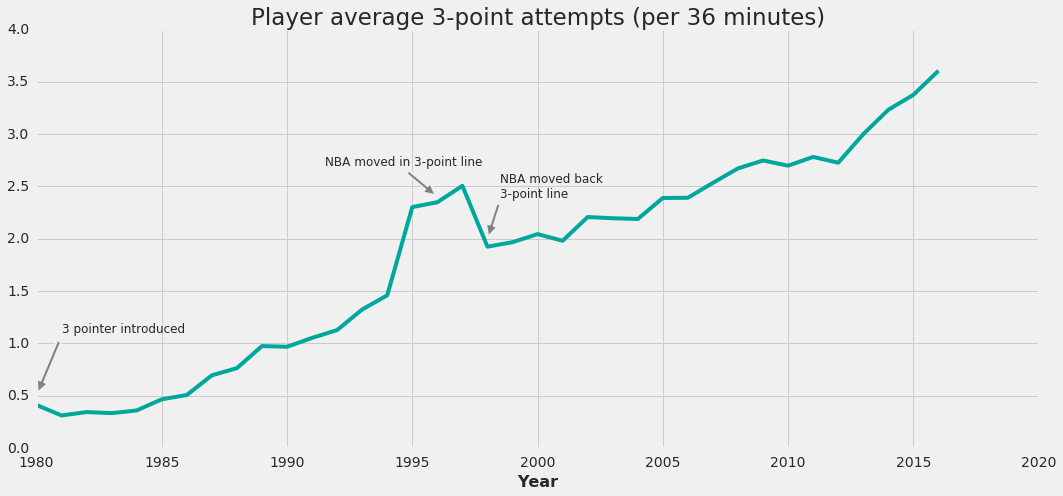

In [21]:
_df = fga_py.toPandas()
plt.plot(_df.yr,_df.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.annotate('3 pointer introduced', xy=(1980, .5), xytext=(1981, 1.1), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.annotate('NBA moved in 3-point line', xy=(1996, 2.4), xytext=(1991.5, 2.7), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))

# Build a linear regression model

In [22]:
# train the model
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')
training = t.transform(fga_py)\
            .withColumn('yr',fga_py.yr)\
            .withColumn('label',fga_py.fg3a_pm)
training.toPandas().head()

,yr,fg3a_pm,features,label
0,1980,0.410089,[1980.0],0.410089
1,1981,0.309376,[1981.0],0.309376
2,1982,0.341511,[1982.0],0.341511
3,1983,0.331479,[1983.0],0.331479
4,1984,0.357110,[1984.0],0.357110


In [23]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training)

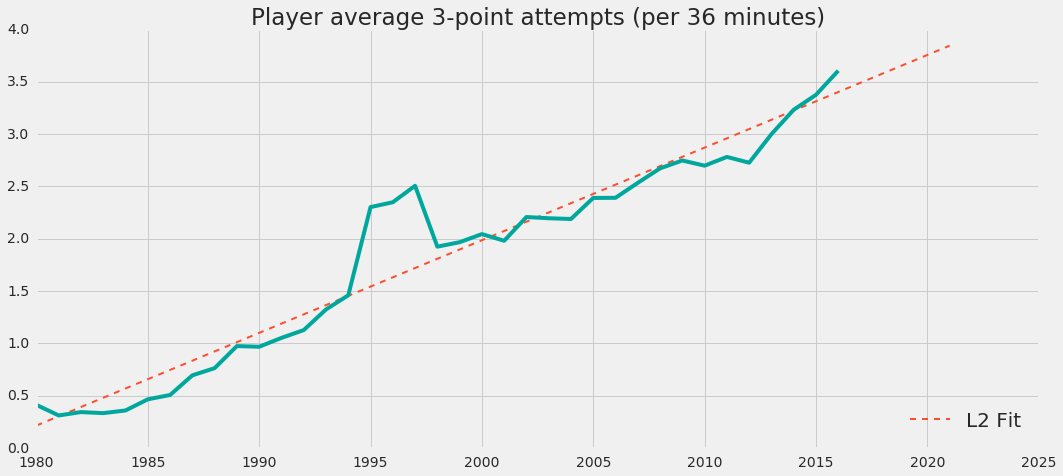

In [24]:
# apply the model
training_yrs = training.select('yr').rdd.map(lambda x: x[0]).collect()
training_y = training.select('fg3a_pm').rdd.map(lambda x: x[0]).collect()

testing_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + testing_yrs

test_rdd = sc.parallelize(all_yrs)
row = Row('yr')
testing = t.transform(test_rdd.map(row).toDF())

df_results = model.transform(testing).toPandas()
plt.plot(df_results.yr,df_results.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(training_yrs, training_y, color = '#00a79c', label = None)
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.savefig('results/model_prediction.png')

# Appendix

## True shooting percentage

In [288]:
def calc_ts_per(row):
    pts,fga,fta = row.PTS,row.FGA,row.FTA
    return pts/(2*(fga + (0.44*fta)))

df_ts = sqlContext.sql('''
SELECT yr, SUM(pts)/(2 * (SUM(fga) + (.44 * SUM(fta)))) as ts_per
FROM df
GROUP BY yr
ORDER BY yr
''').toPandas()

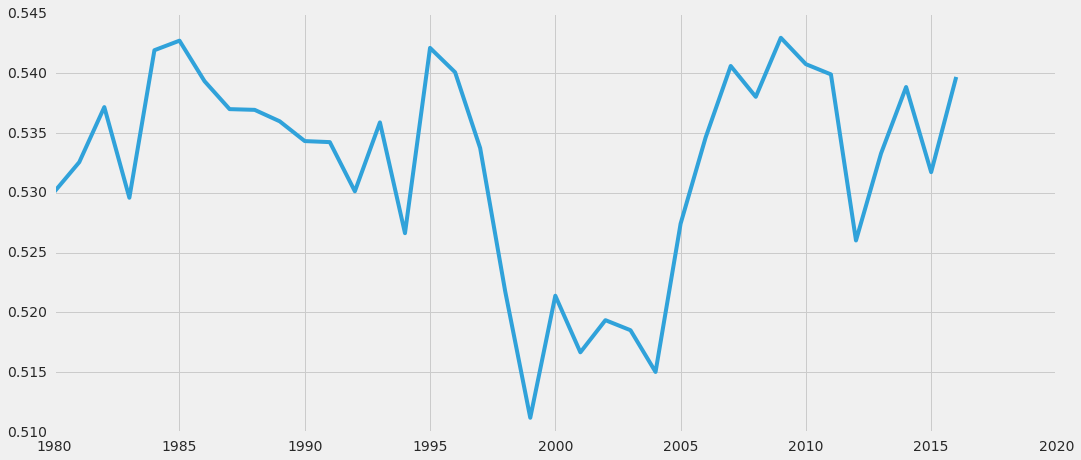

In [289]:
plt.plot(df_ts.yr, df_ts.ts_per)

In [291]:
def calc_ts_per(pts,fga,fta):
    return pts/(2*(fga + (0.44*fta)))

pstats = df.filter('yr < 2010 and mp > 500').toPandas()
pstats['ts'] = calc_ts_per(pstats.pts,pstats.fga,pstats.fta)

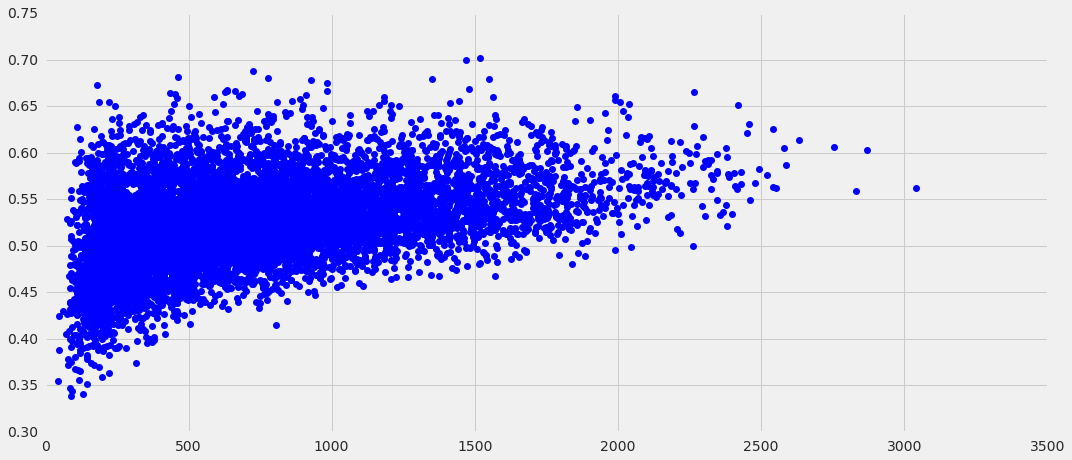

In [292]:
plt.plot(pstats.pts, pstats.ts, 'bo')

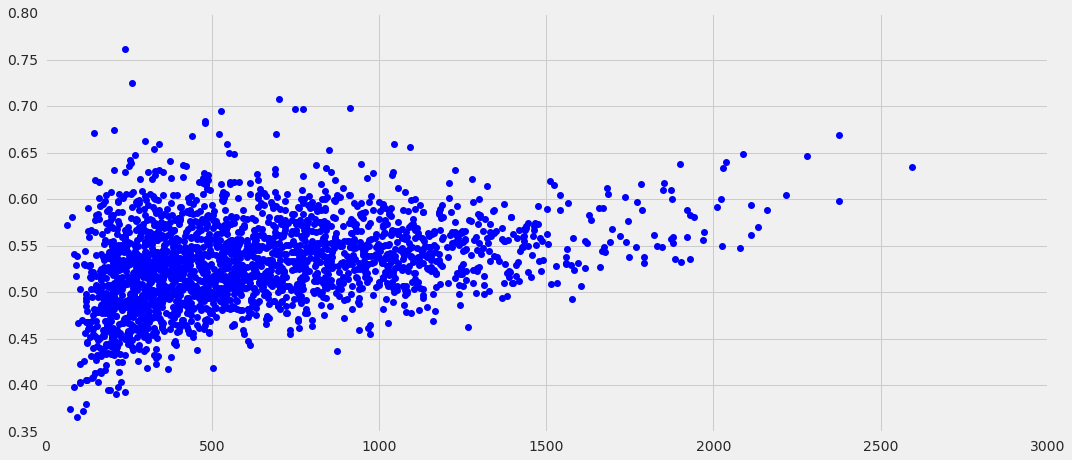

In [290]:
plt.plot(pstats.pts, pstats.ts, 'bo')

## Top 10 players each season

In [28]:
sqlContext.registerDataFrameAsTable(df, 'df')
df_top10 = sqlContext.sql('''
SELECT * 
FROM
(SELECT *,dense_rank() OVER (PARTITION BY yr order by fga DESC) AS rank
FROM df) foo
WHERE rank <= 10
ORDER BY yr
''')
sqlContext.registerDataFrameAsTable(df_top10,'df_top10')

In [30]:
fga_py = df_top10.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\
         .toPandas()

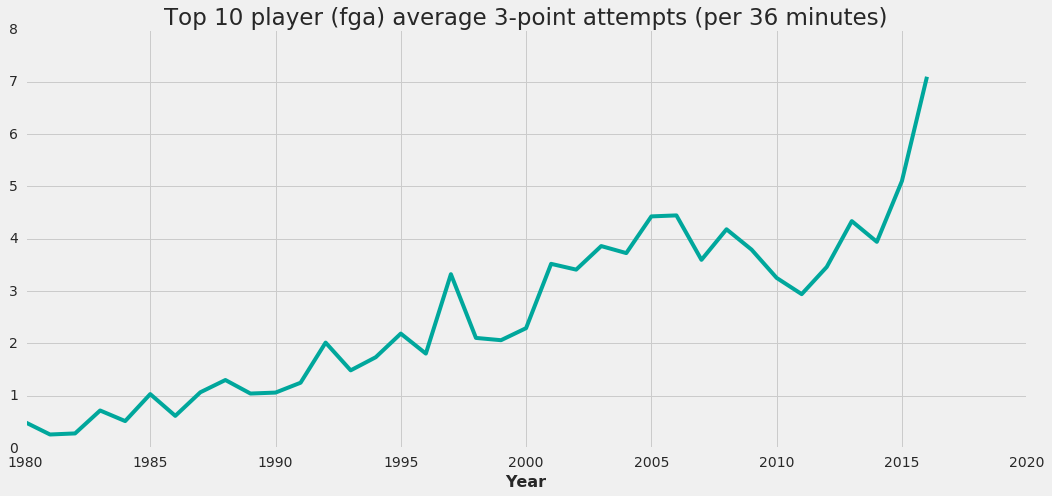

In [31]:
plt.plot(fga_py.yr,36*fga_py.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Top 10 player (fga) average 3-point attempts (per 36 minutes)')